<p><h1><center>Cyber Security & Data Analytics – Malware Analysis</center></h1></p>
<p><h4><center>Team 2: Wei-Ping (Daniel) Lee, Ziwei Liang, Yuzi Liu, Maryna Pavlenko</center></h4></p>
<center>The project's objecticve is to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics.</center>
<h2><a href="https://www.kaggle.com/xwolf12/malicious-and-benign-websites">Data source</a><h2>
   <p><h3><strong>INDEX:</h3></p>
<p>1: <a href="#Data-processing">Data processing</a><br>
2: <a href="#Descriptive-statistics">Descriptive statistics</a><br>
3: <a href="#Visualizations">Visualizations</a><br>
4: <a href="#Machine learning models">Machine learning models</a>

Importing libraries

In [405]:
import numpy as np
import pandas as pd 
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib as mlp
from pandas.plotting import scatter_matrix
import xgboost as xgb
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report,accuracy_score

Reading dataset

In [406]:
dataset=pd.read_csv("C:/Users/Maryna/Desktop/winter HW/dataset.csv")
dataset.head()

URL  URL_LENGTH  NUMBER_SPECIAL_CHARACTERS     CHARSET  \
0   M0_109          16                          7  iso-8859-1   
1  B0_2314          16                          6       UTF-8   
2   B0_911          16                          6    us-ascii   
3   B0_113          17                          6  ISO-8859-1   
4   B0_403          17                          6       UTF-8   

                  SERVER  CONTENT_LENGTH WHOIS_COUNTRY WHOIS_STATEPRO  \
0                  nginx           263.0          None           None   
1          Apache/2.4.10         15087.0          None           None   
2  Microsoft-HTTPAPI/2.0           324.0          None           None   
3                  nginx           162.0            US             AK   
4                   None        124140.0            US             TX   

      WHOIS_REGDATE WHOIS_UPDATED_DATE  ...   DIST_REMOTE_TCP_PORT  \
0  10/10/2015 18:21               None  ...                      0   
1              None               None  ...                      7   
2              None               None  ...                      0   
3    7/10/1997 4:00    12/09/2013 0:45  ...                     22   
4   12/05/1996 0:00    11/04/2017 0:00  ...                      2   

   REMOTE_IPS  APP_BYTES  SOURCE_APP_PACKETS  REMOTE_APP_PACKETS  \
0           2        700                   9                  10   
1           4       1230                  17                  19   
2           0          0                   0                   0   
3           3       3812                  39                  37   
4           5       4278                  61                  62   

   SOURCE_APP_BYTES  REMOTE_APP_BYTES  APP_PACKETS  DNS_QUERY_TIMES  Type  
0              1153               832            9              2.0     1  
1              1265              1230           17              0.0     0  
2                 0                 0            0              0.0     0  
3             18784              4380           39              8.0     0  
4            129889              4586           61              4.0     0  

[5 rows x 21 columns]

Data overview:
1781 values. 21 columns out of which 7 categorical variables

In [407]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
URL                          1781 non-null object
URL_LENGTH                   1781 non-null int64
NUMBER_SPECIAL_CHARACTERS    1781 non-null int64
CHARSET                      1781 non-null object
SERVER                       1780 non-null object
CONTENT_LENGTH               969 non-null float64
WHOIS_COUNTRY                1781 non-null object
WHOIS_STATEPRO               1781 non-null object
WHOIS_REGDATE                1781 non-null object
WHOIS_UPDATED_DATE           1781 non-null object
TCP_CONVERSATION_EXCHANGE    1781 non-null int64
DIST_REMOTE_TCP_PORT         1781 non-null int64
REMOTE_IPS                   1781 non-null int64
APP_BYTES                    1781 non-null int64
SOURCE_APP_PACKETS           1781 non-null int64
REMOTE_APP_PACKETS           1781 non-null int64
SOURCE_APP_BYTES             1781 non-null int64
REMOTE_APP_BYTES             1781 non-null int64
APP

<h3 id="Data-processing">Data processing<a class="anchor-link" href="#Data-processing">&#182;</a></h3>
a) removing redundant variables: "URL" variable with unique values and dates which are not needed our for classification and prediction analysis

In [408]:
dataset.drop(["URL", "WHOIS_REGDATE", "WHOIS_UPDATED_DATE"], axis=1, inplace = True)

b) Detection and interpolation of missing values

In [409]:
print(dataset.isnull().sum())

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64


In [410]:
dataset = dataset.interpolate()
print(dataset.isnull().sum())

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       1
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64


c) Feature Engineering on Categorical Data

In [411]:
dataset["SERVER"].value_counts()

Apache                                                                                                                386
nginx                                                                                                                 211
None                                                                                                                  175
Microsoft-HTTPAPI/2.0                                                                                                 113
cloudflare-nginx                                                                                                       94
Microsoft-IIS/7.5                                                                                                      51
GSE                                                                                                                    49
Server                                                                                                                 49
YouTubeFrontEnd         

In [412]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
series = pd.value_counts(dataset.SERVER)
mask = (series/series.sum() * 100).lt(1)
dataset['SERVER'] = np.where(dataset['SERVER'].isin(series[mask].index),'Other',dataset['SERVER'])

In [413]:
dataset["SERVER"].value_counts()

Other                     499
Apache                    386
nginx                     211
None                      175
Microsoft-HTTPAPI/2.0     113
cloudflare-nginx           94
Microsoft-IIS/7.5          51
GSE                        49
Server                     49
YouTubeFrontEnd            42
nginx/1.12.0               36
ATS                        30
Apache/2.2.15 (CentOS)     25
Apache-Coyote/1.1          20
Name: SERVER, dtype: int64

In [414]:
dataset["CHARSET"].value_counts()

UTF-8           676
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
ISO-8859          1
windows-1252      1
windows-1251      1
Name: CHARSET, dtype: int64

In [415]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
series = pd.value_counts(dataset.CHARSET)
mask = (series/series.sum() * 100).lt(1)
dataset['CHARSET'] = np.where(dataset['CHARSET'].isin(series[mask].index),'Other',dataset['CHARSET'])

In [416]:
dataset["WHOIS_COUNTRY"].value_counts()

US                1103
None               306
CA                  84
ES                  63
AU                  35
PA                  21
GB                  19
JP                  11
CN                  10
IN                  10
UK                  10
FR                   9
CZ                   9
CH                   6
NL                   6
[u'GB'; u'UK']       5
KR                   5
AT                   4
PH                   4
BS                   4
ru                   4
SC                   3
DE                   3
KY                   3
us                   3
TR                   3
HK                   3
BE                   3
SE                   3
RU                   2
Cyprus               2
KG                   2
SI                   2
NO                   2
IL                   2
BR                   2
UA                   2
UY                   2
PK                   1
LU                   1
LV                   1
BY                   1
IT                   1
AE         

In [417]:
#Handling duplicate values for countries
def replace(x):
    if x == "[u'GB'; u'UK']"or x=="United Kingdom" or x=="UK":
        return "GB"
    elif x == "Cyprus":
        return "CY"
    elif x == "us":
        return "US"
    elif x == "ru":
        return "RU"
    elif x == "se":
        return "SE"
    else:
        return x
    
dataset["WHOIS_COUNTRY"] = list(map(lambda x: replace(x), dataset["WHOIS_COUNTRY"]))

In [418]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
counts = dataset['WHOIS_COUNTRY'].value_counts()
dataset['WHOIS_COUNTRY'] = np.where(dataset['WHOIS_COUNTRY'].isin(counts[counts < 10].index),'Other',dataset['WHOIS_COUNTRY'])

In [419]:
dataset["WHOIS_COUNTRY"].value_counts()

US       1106
None      306
Other     100
CA         84
ES         63
AU         35
GB         35
PA         21
JP         11
IN         10
CN         10
Name: WHOIS_COUNTRY, dtype: int64

In [420]:
dataset["WHOIS_STATEPRO"].value_counts()

CA                      372
None                    362
NY                       75
WA                       65
Barcelona                62
FL                       61
Arizona                  58
California               57
ON                       45
NV                       30
UT                       29
CO                       24
PA                       23
MA                       22
PANAMA                   19
IL                       19
NJ                       15
Ohio                     15
MO                       15
Queensland               14
Utah                     13
New York                 11
VA                       10
Washington               10
TX                       10
Quebec                    9
Texas                     9
GA                        8
Illinois                  8
PRAHA                     8
                       ... 
OR                        1
-                         1
VT                        1
District of Columbia      1
Maharashtra         

In [421]:
#Handling duplicate values for States
def replace_ny_ca(x):
    if x == "California"or x=="CALIFORNIA":
        return "CA"
    elif x == "Arizona":
        return "AZ"
    elif x == "New York" or x=="NEW YORK":
        return "NY"
    elif x == "Ohio":
        return "OH"
    elif x == "Utah":
        return "UT"
    elif x == "None":
        return "NA"
    elif x == "Texas":
        return "TX"
    elif x == "Washington":
        return "WA"
    elif x == "va":
        return "VA"
    elif x == "Illinois" or x=="il":
        return "IL"
    elif x == "District of Columbia" or x=="DC" or x=="Maryland":
        return "MD"
    elif x == "New Jersey":
        return "NJ"
    elif x == "Maine" or x=="MAINE":
        return "ME"
    elif x == "Quebec" or x=="QUEBEC" or x=="qc" or x=="quebec":
        return "QC"
    elif x == "Missouri":
        return "MO"
    elif x == "Nevada":
        return "NV"
    elif x == "WC1N" or x=="Greater London" or x=="UK" or x=="WEST MIDLANDS" or x=="worcs" or x=="Peterborough" or x=="London" or x=="HANTS" or x=="MIDDLESEX":
        return "England"
    elif x == "Pennsylvania":
        return "PA"
    elif x == "Florida" or x=="FLORIDA":
        return "FL"
    else:
        return x
    
dataset["WHOIS_STATEPRO"] = list(map(lambda x: replace_ny_ca(x), dataset["WHOIS_STATEPRO"]))

In [422]:
#Indentifying missing State values based on country column
for i,v in dataset.iterrows():
    if v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='GB':
            print ('England')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='SE':
            print ('Sweden')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='LU':
            print ('Luxembourg')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='FR':
            print ('France')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='IL':
            print ('Israel')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='BE':
            print ('Belgium')        
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='NO':
            print ('Norway')        
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='TR':
            print ('Turkey')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='DE':
            print ('Germany')      
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='BR':
            print ('Brazil')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='JP':
            print ('Japan')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='AU':
            print ('Australia')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='PH':
            print ('Philippines')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='CZ':
            print ('CzechRep')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='KR':
            print ('SKorea')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='UA':
            print ('Ukraine')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='HK':
            print ('Hong Kong')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='CH':
            print ('Switzerland')
    elif v['WHOIS_STATEPRO']=='None' and v['WHOIS_COUNTRY']=='CY':
            print ('Cypres')
        

In [423]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
counts = dataset['WHOIS_STATEPRO'].value_counts()
dataset['WHOIS_STATEPRO'] = np.where(dataset['WHOIS_STATEPRO'].isin(counts[counts < 20].index),'Other',dataset['WHOIS_STATEPRO'])

In [424]:
dataset["WHOIS_STATEPRO"].value_counts()

CA           430
NA           362
Other        347
NY            87
WA            75
FL            67
AZ            64
Barcelona     62
ON            45
UT            42
NV            33
PA            28
IL            28
CO            24
England       22
MA            22
MO            22
OH            21
Name: WHOIS_STATEPRO, dtype: int64

In [425]:
#binary encoding of categirical variables
dataset_ce = dataset.copy()
encoder = ce.BinaryEncoder(cols=['WHOIS_STATEPRO','WHOIS_COUNTRY', 'CHARSET', 'SERVER'])
df_binary = encoder.fit_transform(dataset_ce)
df_binary.head()

WHOIS_STATEPRO_0  WHOIS_STATEPRO_1  WHOIS_STATEPRO_2  WHOIS_STATEPRO_3  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   WHOIS_STATEPRO_4  WHOIS_STATEPRO_5  WHOIS_COUNTRY_0  WHOIS_COUNTRY_1  \
0                 0                 1                0                0   
1                 0                 1                0                0   
2                 0                 1                0                0   
3                 1                 0                0                0   
4                 1                 0                0                0   

   WHOIS_COUNTRY_2  WHOIS_COUNTRY_3  ...   DIST_REMOTE_TCP_PORT  REMOTE_IPS  \
0                0                0  ...                      0           2   
1                0                0  ...                      7           4   
2                0                0  ...                      0           0   
3                0                1  ...                     22           3   
4                0                1  ...                      2           5   

   APP_BYTES  SOURCE_APP_PACKETS  REMOTE_APP_PACKETS  SOURCE_APP_BYTES  \
0        700                   9                  10              1153   
1       1230                  17                  19              1265   
2          0                   0                   0                 0   
3       3812                  39                  37             18784   
4       4278                  61                  62            129889   

   REMOTE_APP_BYTES  APP_PACKETS  DNS_QUERY_TIMES  Type  
0               832            9              2.0     1  
1              1230           17              0.0     0  
2                 0            0              0.0     0  
3              4380           39              8.0     0  
4              4586           61              4.0     0  

[5 rows x 34 columns]

<h3 id=Descriptive-statistics>Descriptive statistics<a class="anchor-link" href="#"Descriptive-statistics">&#182;</a></h3>

In [426]:
dataset.describe()

URL_LENGTH  NUMBER_SPECIAL_CHARACTERS  CONTENT_LENGTH  \
count  1781.000000                1781.000000     1781.000000   
mean     56.961258                  11.111735    13497.243964   
std      27.555586                   4.549896    38415.552697   
min      16.000000                   5.000000        0.000000   
25%      39.000000                   8.000000      603.000000   
50%      49.000000                  10.000000     4714.750000   
75%      68.000000                  13.000000    12578.500000   
max     249.000000                  43.000000   649263.000000   

       TCP_CONVERSATION_EXCHANGE  DIST_REMOTE_TCP_PORT   REMOTE_IPS  \
count                1781.000000           1781.000000  1781.000000   
mean                   16.261089              5.472768     3.060640   
std                    40.500975             21.807327     3.386975   
min                     0.000000              0.000000     0.000000   
25%                     0.000000              0.000000     0.000000   
50%                     7.000000              0.000000     2.000000   
75%                    22.000000              5.000000     5.000000   
max                  1194.000000            708.000000    17.000000   

          APP_BYTES  SOURCE_APP_PACKETS  REMOTE_APP_PACKETS  SOURCE_APP_BYTES  \
count  1.781000e+03         1781.000000         1781.000000      1.781000e+03   
mean   2.982339e+03           18.540146           18.746210      1.589255e+04   
std    5.605057e+04           41.627173           46.397969      6.986193e+04   
min    0.000000e+00            0.000000            0.000000      0.000000e+00   
25%    0.000000e+00            0.000000            0.000000      0.000000e+00   
50%    6.720000e+02            8.000000            9.000000      5.790000e+02   
75%    2.328000e+03           26.000000           25.000000      9.806000e+03   
max    2.362906e+06         1198.000000         1284.000000      2.060012e+06   

       REMOTE_APP_BYTES  APP_PACKETS  DNS_QUERY_TIMES         Type  
count      1.781000e+03  1781.000000      1781.000000  1781.000000  
mean       3.155599e+03    18.540146         2.263335     0.121280  
std        5.605378e+04    41.627173         2.930036     0.326544  
min        0.000000e+00     0.000000         0.000000     0.000000  
25%        0.000000e+00     0.000000         0.000000     0.000000  
50%        7.350000e+02     8.000000         0.000000     0.000000  
75%        2.701000e+03    26.000000         4.000000     0.000000  
max        2.362906e+06  1198.000000        20.000000     1.000000

<h3 id="Visualizations">Visualizations<a class="anchor-link" href="#Visualizations">&#182;</a></h3>

<Figure size 1152x432 with 0 Axes>

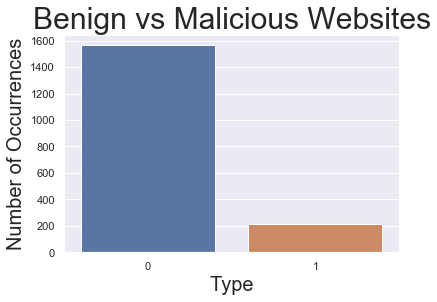

<Figure size 1152x432 with 0 Axes>

In [427]:
%matplotlib inline
sns.set(style="darkgrid")
sns.countplot(x="Type", data=dataset)
plt.title('Benign vs Malicious Websites',fontsize=30)
plt.ylabel('Number of Occurrences',fontsize=20)
plt.xlabel('Type',fontsize=20)
plt.figure(figsize=(16, 6))

In [428]:
#Segregating the classes 
yes = dataset[dataset.Type == 1]
no = dataset[dataset.Type == 0]
print('YES : %d  No: %d'%(len(yes), len(no)))

YES : 216  No: 1565


In [429]:
ratio=round(len(yes)/(len(yes)+len(no))*100)
print("Malitious websites ratio is",ratio,"%")

Malitious websites ratio is 12 %


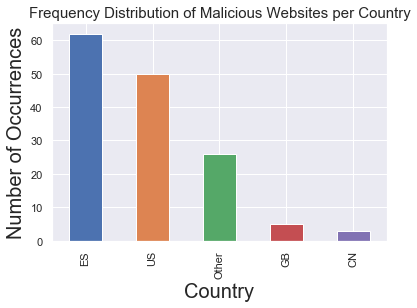

In [430]:
dataset.drop(dataset.loc[dataset['WHOIS_COUNTRY']=="None"].index, inplace=True)
dataset[dataset['Type']==1].groupby('WHOIS_COUNTRY')['WHOIS_COUNTRY'].count().sort_values(ascending=False).head(5).plot(kind='bar')
sns.set(style="darkgrid")
plt.title('Frequency Distribution of Malicious Websites per Country',fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.show()

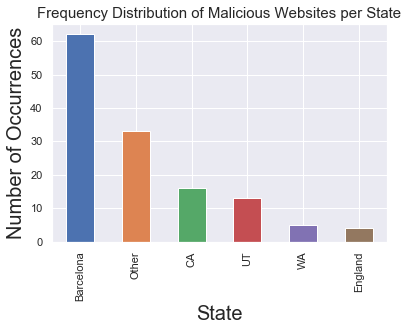

In [431]:
dataset.drop(dataset.loc[dataset['WHOIS_STATEPRO']=="NA"].index, inplace=True)
dataset[dataset['Type']==1].groupby('WHOIS_STATEPRO')['WHOIS_STATEPRO'].count().sort_values(ascending=False).head(6).plot(kind='bar')
sns.set(style="darkgrid")
plt.title('Frequency Distribution of Malicious Websites per State', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('State', fontsize=20)
plt.show()

Text(0.5, 0, 'Charset')

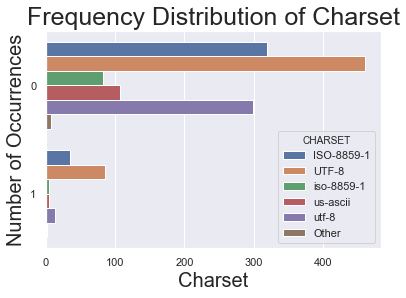

In [432]:
sns.countplot(y="Type", hue='CHARSET', data=dataset)
plt.title('Frequency Distribution of Charset',fontsize=25)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Charset', fontsize=20)

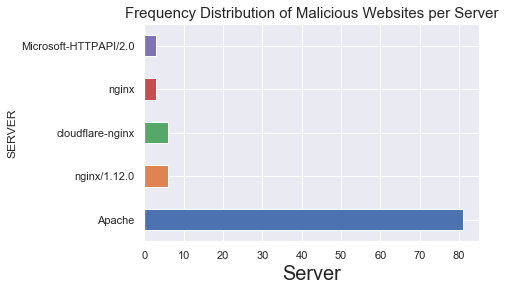

In [433]:
dataset.drop(dataset.loc[dataset['SERVER']=="Other"].index, inplace=True)
dataset[dataset['Type']==1].groupby('SERVER')['SERVER'].count().sort_values(ascending=False).head(5).plot(kind='barh')
sns.set(style="darkgrid")
plt.title('Frequency Distribution of Malicious Websites per Server',fontsize=15)
plt.xlabel('Server', fontsize=20)
plt.show()

C:\Users\Maryna\New folder\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



(0, 80)

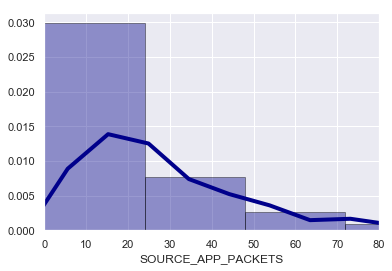

In [434]:
#Density distribution of SOURCE_APP_PACKETS
#Mean value is in the range of 14 and 18. right skewed
sns.distplot(df_binary['SOURCE_APP_PACKETS'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 80)

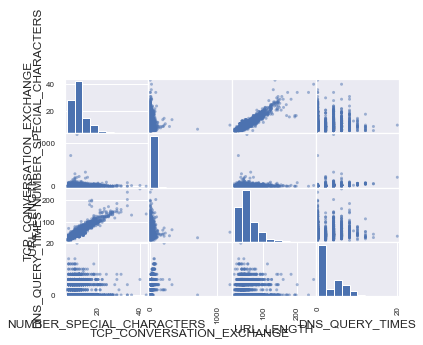

In [435]:
#Positive correlation among some of the variables and right skewed histograms are observed
scatter_matrix(df_binary[['NUMBER_SPECIAL_CHARACTERS','TCP_CONVERSATION_EXCHANGE','URL_LENGTH','DNS_QUERY_TIMES']])
plt.show()

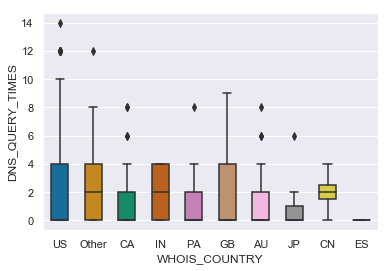

In [436]:
bplot = sns.boxplot(y='DNS_QUERY_TIMES', x='WHOIS_COUNTRY', 
                 data=dataset, 
                 width=0.5,
                 palette="colorblind")

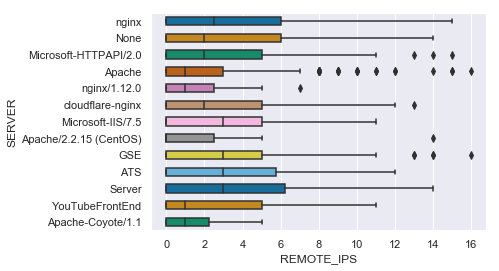

In [437]:
bplot = sns.boxplot(x='REMOTE_IPS', y='SERVER', 
                 data=dataset, 
                 width=0.5,
                 palette="colorblind")

<h3 id="Machine learning models">Machine learning models<a class="anchor-link" href="#Machine learning models">&#182;</a></h3>

##### Feature importance

In [438]:
#split dataset in features and target variable
X = df_binary.drop('Type',axis=1) #Predictors
y = df_binary['Type']
#apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                        Specs         Score
29           SOURCE_APP_BYTES  1.051184e+06
22             CONTENT_LENGTH  2.819265e+05
26                  APP_BYTES  2.378437e+05
30           REMOTE_APP_BYTES  2.146202e+05
24       DIST_REMOTE_TCP_PORT  1.063633e+03
20                 URL_LENGTH  6.235178e+02
7             WHOIS_COUNTRY_1  2.975855e+02
23  TCP_CONVERSATION_EXCHANGE  2.901959e+02
21  NUMBER_SPECIAL_CHARACTERS  2.616580e+02
1            WHOIS_STATEPRO_1  2.334727e+02
28         REMOTE_APP_PACKETS  2.212112e+02
27         SOURCE_APP_PACKETS  1.970290e+02
31                APP_PACKETS  1.970290e+02
10            WHOIS_COUNTRY_4  1.417818e+02
3            WHOIS_STATEPRO_3  5.739644e+01


#### Decision Tree Model

In [439]:
feature_cols = ['SOURCE_APP_BYTES','CONTENT_LENGTH','APP_BYTES', 'REMOTE_APP_BYTES', 'DIST_REMOTE_TCP_PORT', 'URL_LENGTH',
                'WHOIS_COUNTRY_1','TCP_CONVERSATION_EXCHANGE', 'NUMBER_SPECIAL_CHARACTERS', 'WHOIS_STATEPRO_1',
                'REMOTE_APP_PACKETS', 'SOURCE_APP_PACKETS', 'APP_PACKETS','WHOIS_COUNTRY_4','WHOIS_STATEPRO_3']
X = df_binary[feature_cols] # Features
y = df_binary.Type # Target variable

In [440]:
# To understand model performance, dividing the dataset into a training set and a test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [441]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=12)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9523809523809523


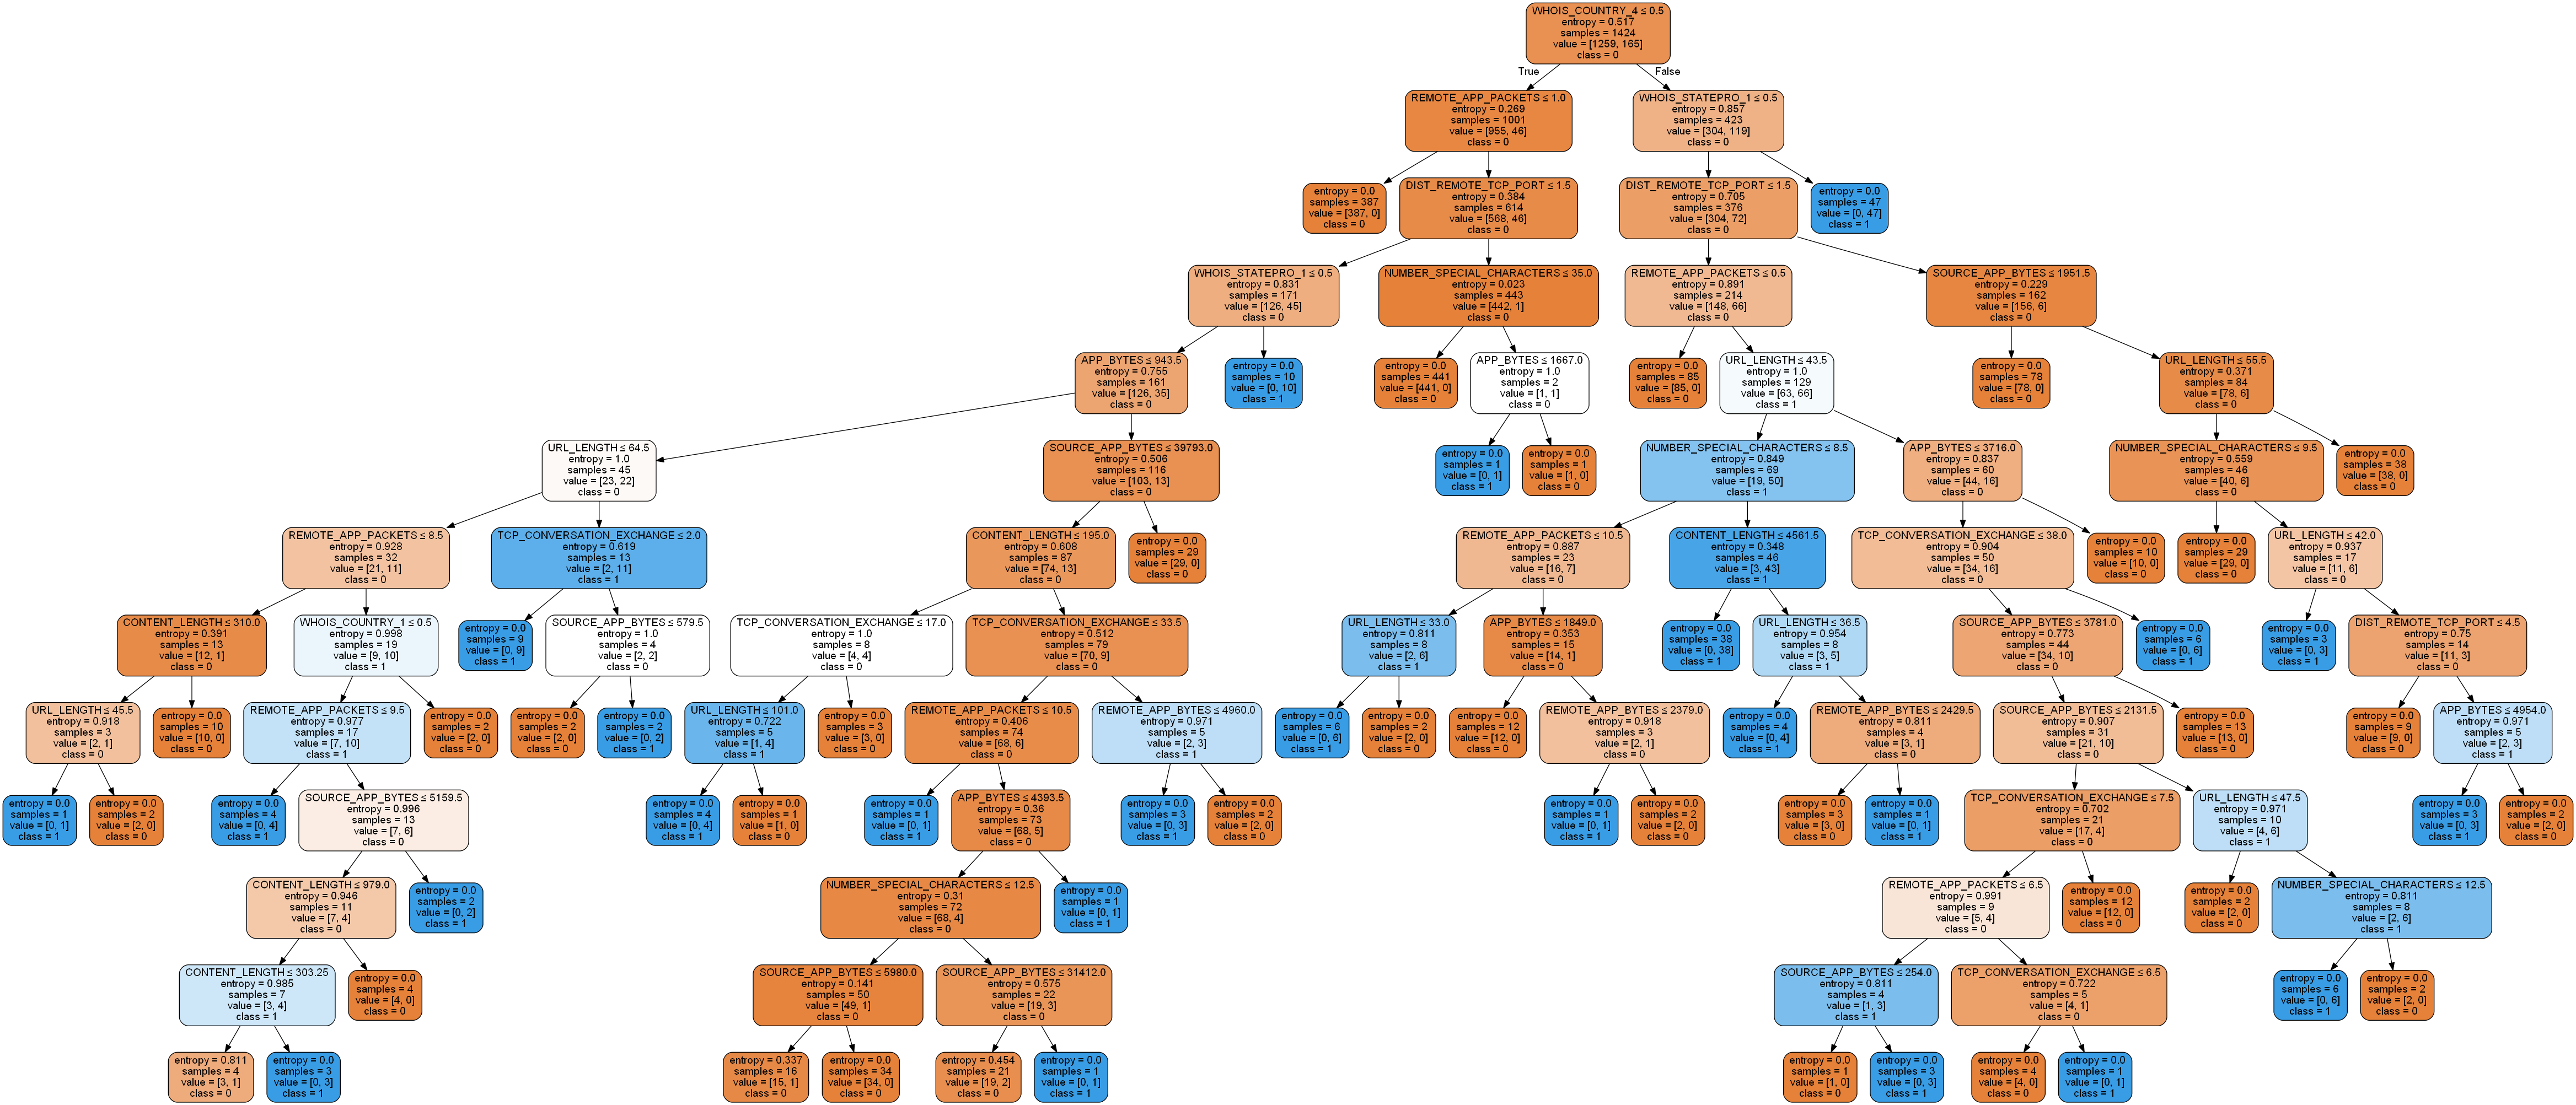

In [442]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Random Forest

In [443]:
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=rf.predict(X_test)
rf.fit(X_train,y_train)

y_pred=rf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9467787114845938


In [444]:
# Visualize our results
def print_score(classifier,X_train,Y_train,X_test,Y_test,train=True):
    if train == True:
        print("Training results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(Y_train,classifier.predict(X_train))))
        print('Classification Report:\n{}\n'.format(classification_report(Y_train,classifier.predict(X_train))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(Y_train,classifier.predict(X_train))))
        res = cross_val_score(classifier, X_train, Y_train, cv=10, n_jobs=-1, scoring='accuracy')
        print('Average Accuracy:\t{0:.4f}\n'.format(res.mean()))
        print('Standard Deviation:\t{0:.4f}'.format(res.std()))
    elif train == False:
        print("Test results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(Y_test,classifier.predict(X_test))))
        print('Classification Report:\n{}\n'.format(classification_report(Y_test,classifier.predict(X_test))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(Y_test,classifier.predict(X_test))))

print_score(rf,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9468

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       306
           1       0.94      0.67      0.78        51

   micro avg       0.95      0.95      0.95       357
   macro avg       0.95      0.83      0.88       357
weighted avg       0.95      0.95      0.94       357


Confusion Matrix:
[[304   2]
 [ 17  34]]



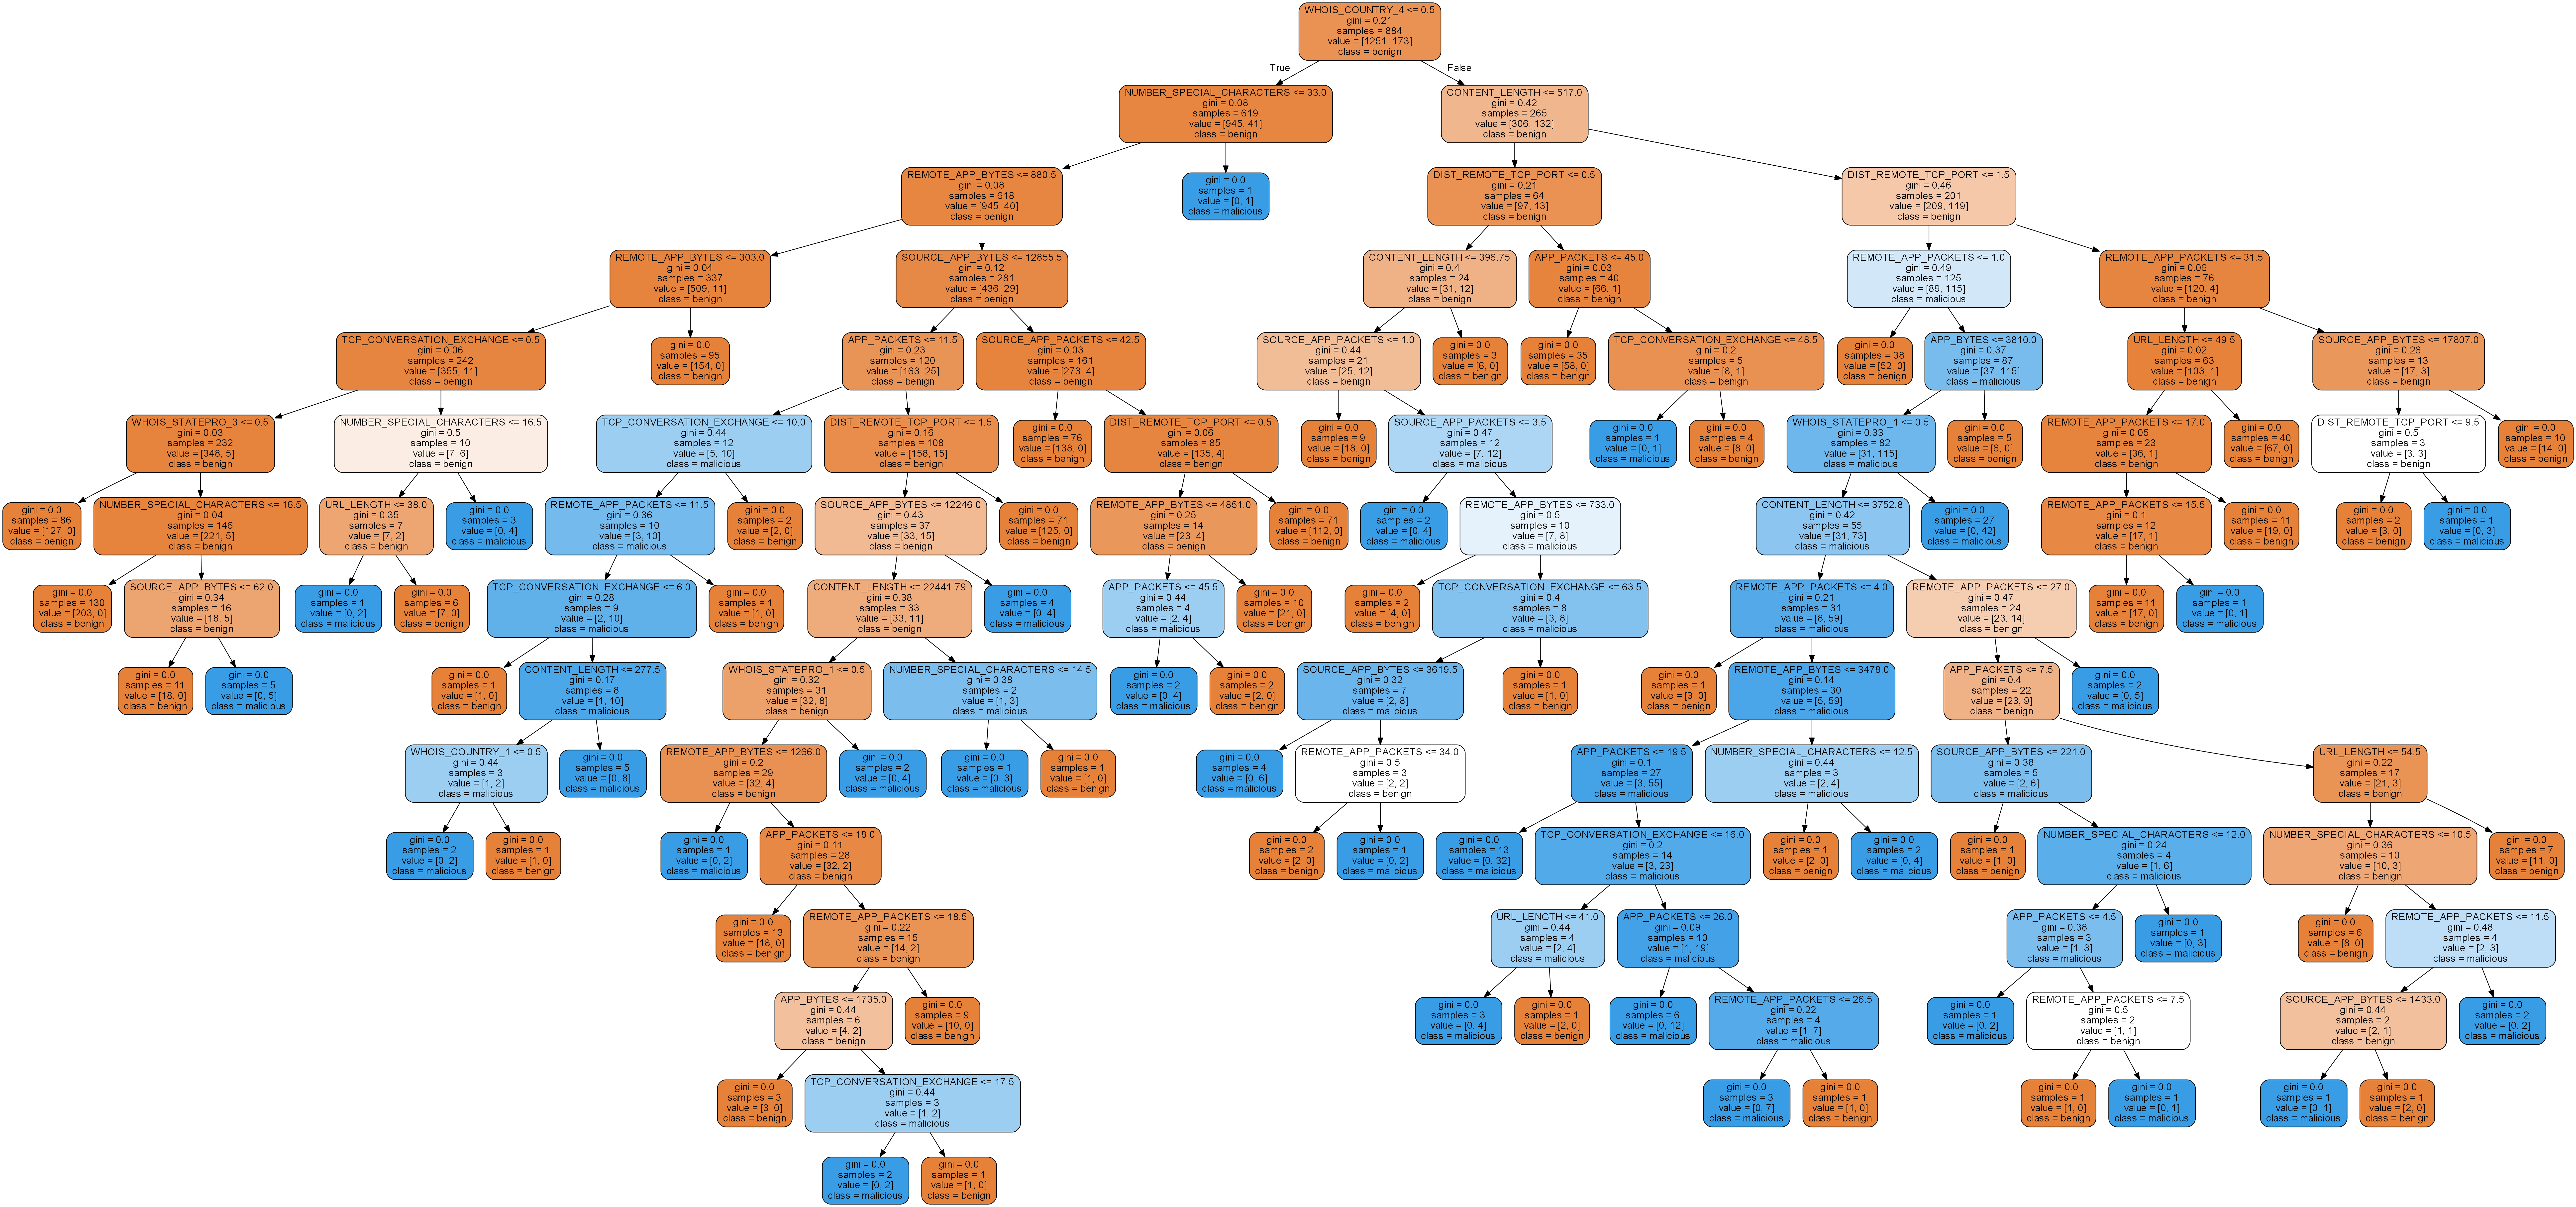

In [445]:
def create_graph(forest, feature_names):
    estimator = forest.estimators_[5]

    export_graphviz(estimator, out_file='tree.dot',
                    feature_names = feature_names,
                    class_names = ['benign', 'malicious'],
                    rounded = True, proportion = False, precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=200'])
create_graph(rf, list(X))
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Xgboost model

In [446]:
#Converting the dataset into an optimized data structure called Dmatrix 
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\Maryna\New folder\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\Maryna\New folder\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [447]:
#Instantiating XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the 
#hyper-parameters passed as arguments
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [448]:
#Fitting the regressor to the training set and making predictions on the test set 
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [449]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.284922


In [450]:
#In order to build more robust models, let's do a k-fold cross validation where all the entries in the 
#original training dataset are used for both training as well as validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [451]:
# RMSE for prediction has reduced as compared to the first time
print((cv_results["test-rmse-mean"]).tail(1))

49    0.219681
Name: test-rmse-mean, dtype: float64


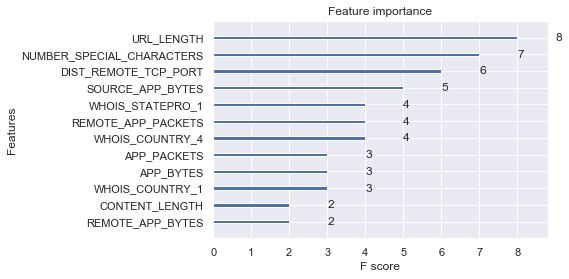

In [452]:
#Plotting feature importance
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

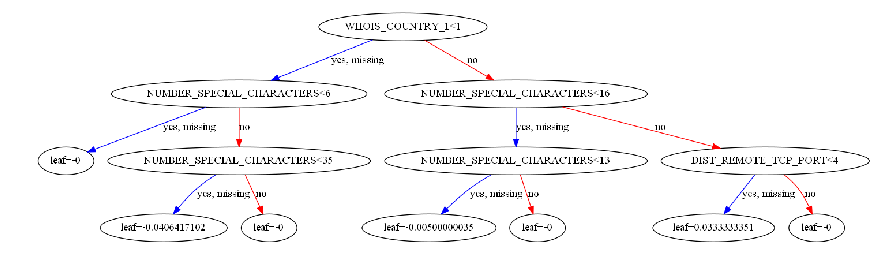

In [454]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()